# HW : Missing data imputation with gibbs sampling
### 교재 7.5 장
### 과제의 흐름?
* 이번 과제에서는 먼저 diabetes dataset에서 glucose, bloodpressure, skinthickness, BMI 4개의 columns에서 missing data(NA)를 찾고 original data의 분포를 먼저 그려봅니다.
* 그 후 첫번째로 sample mean을 이용하여 NA를 처리하는 방법을 볼텐데, 그 결과의 분포가 original 분포와 차이가 있어 좋지 못한 방법이라는 것을 알 수 있을 것 입니다.
* 마지막으로 gibbs sampling을 이용해 NA를 처리하는데, 그 결과의 분포가 original 분포와 유사하다는 것을 확인하며 이전의 방법보다 좋다라는 것을 알 수 있을 것입니다.

### CONTENTS
#### 1. Importing
#### 2. Data Load
#### 3. Make NA
#### 4. Check NA
#### 5. Setting Priors
#### 6. Method 1 : Filling with sample mean
#### * 7. Method 2 : Filling with Gibbs sampling

## 1. Importing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import wishart

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

## Data Load

In [2]:
diabetes = pd.read_csv('C:/Users/USER/Desktop/YONSEI/ESC/22-2 summer/week 4/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# only need 4 columns
data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']]
data.isna().sum()

Glucose          0
BloodPressure    0
SkinThickness    0
BMI              0
dtype: int64

데이터에 있는 glucose, bloodpressure, skinthickness, BMI 가 0일리는 없음
missing data를 0값으로 둔거라 0을 NA로 바꾼다.

## 3. Make NA

In [4]:
# Change zero values to NaN (null)
data = data.replace(0, np.nan)
print(data.isnull().sum())

Glucose            5
BloodPressure     35
SkinThickness    227
BMI               11
dtype: int64


## 4. Check NA

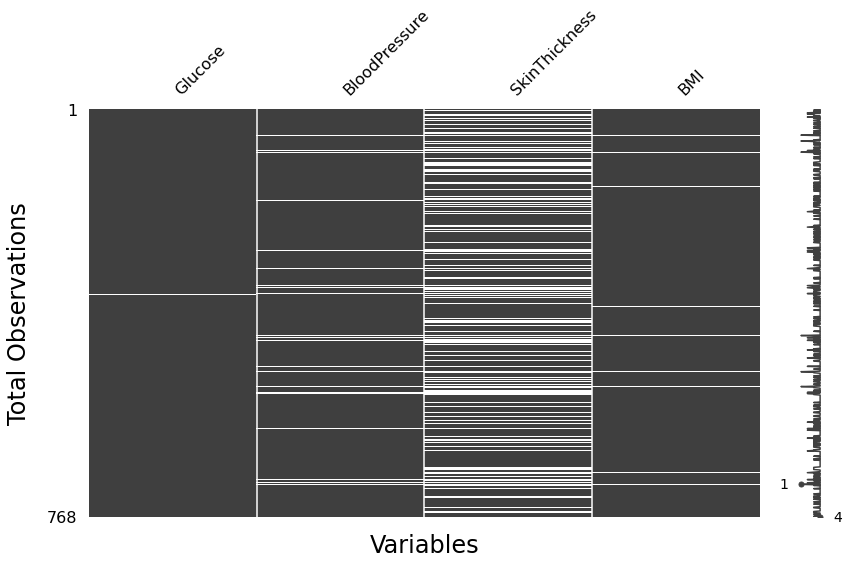

In [5]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(data, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show()

missing data가 생성된걸 확인 할 수 있다.

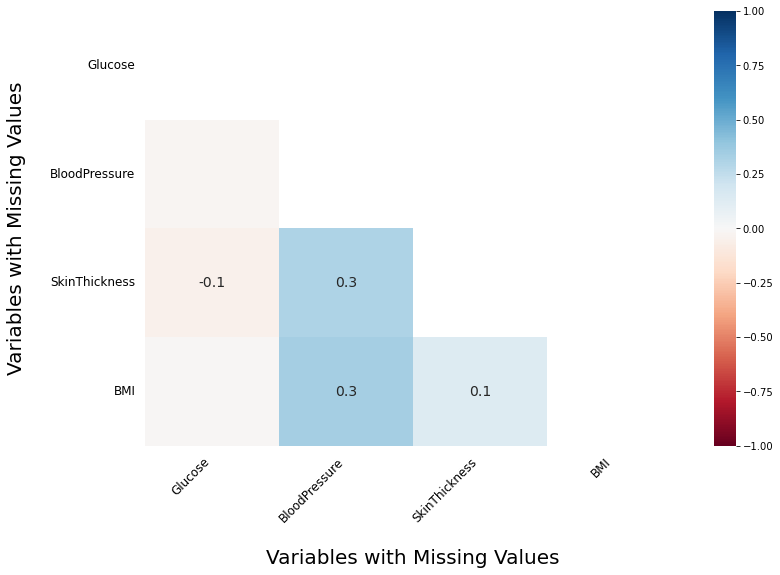

In [6]:
# Visualize the number of missing values as a heatmap
fig = msno.heatmap(data, figsize=(12,8))

# Add labels
plt.xlabel('Variables with Missing Values', size=20, labelpad=24)
plt.ylabel('Variables with Missing Values', size=20, labelpad=24)
plt.tick_params(axis='both', labelsize=12, length=6)

plt.show();

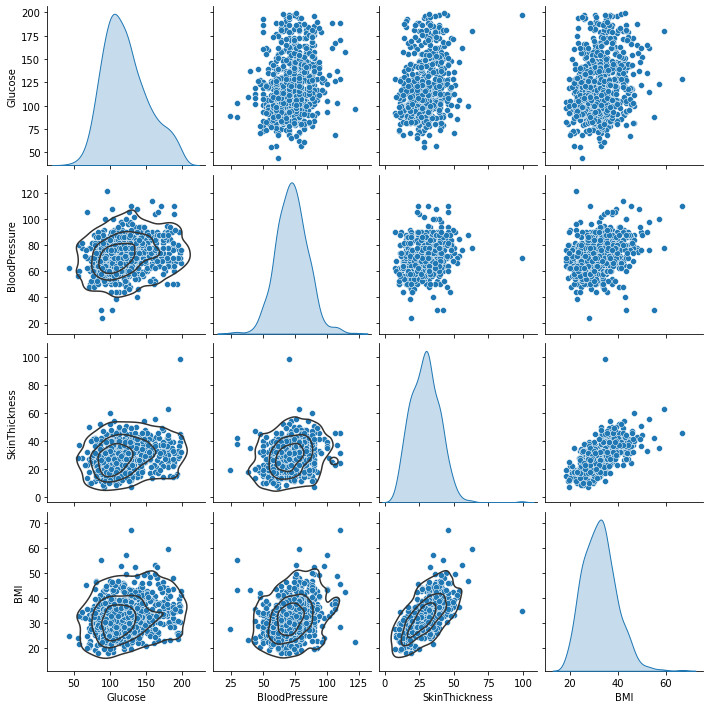

In [7]:
g = sns.pairplot(data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

## 5. Setting Priors

In [7]:
n = data.shape[0]       # data 수
p = data.shape[1]       # column 수

S = 100                 # number of iteration

# 자주 쓰는 함수
inv = np.linalg.inv     # inverse matrix
t = np.transpose        # transpose
mul = np.matmul         # matrix multiplication

In [8]:
# priors (initializing params of prior dist)

## 1. prior for mu ~ N(mu0,L0)
# 1.1 mean vector mu0
mu0 = data.mean().to_numpy()    # column mean

# 1.2 covariance matrix Lambda0 : 공분산 행렬 만들기
# 정확한 이유는 모르지만 나름의 믿음으로 prior params intializing
sd0 = mu0 / 2                   
L0 = np.ones((p,p))*0.1         # Lambda0 in prior   
di = np.diag_indices(p)         # diagonal index
L0[di] = 1                      # all variance = 1
L0 = L0 * np.outer(sd0, sd0)    # off-diagonal elements

## 2. prior for Sigma ~ Ing-Wishart(nu0,S0)
nu0 = p + 2                     
S0 = (n-p-1) * L0

## 6. Method 1 : Filling with sample mean

In [10]:
# setting
Sigma = S0                      # mu의 full conditional posterior를 초기화하는데 필요
fill_data = data.copy()         # imputate할 dataset copy

# O_(i,j)
O = data.isna().to_numpy()*1    # indicator variable (missing = 1, observed = 0)

# Naive Imputation(Using sample mean)
for col in fill_data.columns:
    fill_data[col].fillna(fill_data[col].mean(), inplace=True)

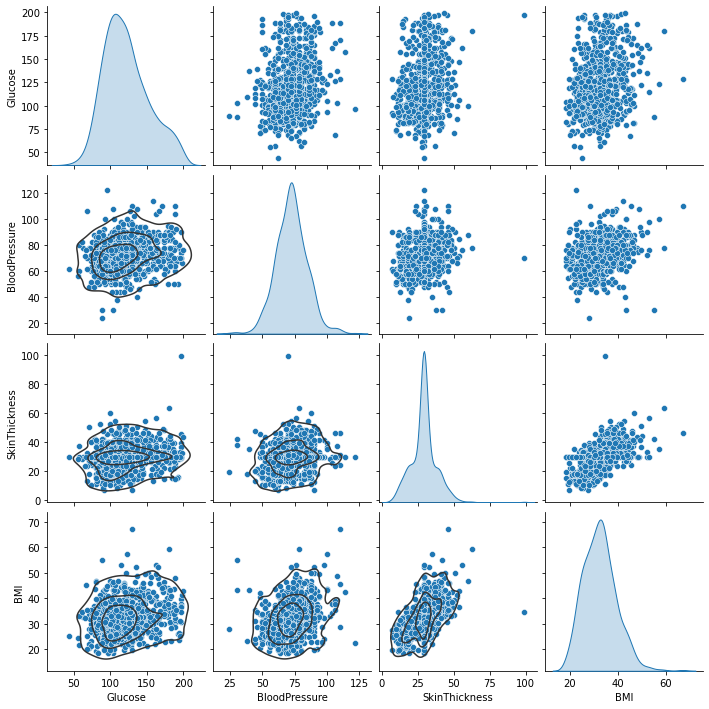

In [12]:
g_naive = sns.pairplot(fill_data, diag_kind="kde")
g_naive.map_lower(sns.kdeplot, levels=4, color=".2")

#### 위 4.에서 구한 데이터의 분포와 비교했을 때 SkinThickness의 분포 모양이 눈에 띄게 차이남.
#### sample mean으로 impute 하는데 문제가 있다는 뜻.

## * 7. Method 2 : Filling with Gibbs sampling

In [14]:
# inv, mul 쓰세요!
inv = np.linalg.inv
mul = np.matmul

for s in range(S):
    # update mu
    ybar = fill_data.mean().to_numpy()
    ######################## TO DO #############################
    # Mu를 sampling 하기 위해서는 아래의 'multivariate_normal.rvs(mun, Ln)'에 들어가는
    # mun 과 Ln을 매번 update해줘야 하기때문에 아래에서 @를 알맞은 값 또는 식으로 바꾸어보아요.
    # hint1 : 교재 equation (7.4) (7.5) 참고
    # hint2 : inv, mul을 사용하고 prior parameter(L0, Sigma, mu0)를 잘 사용해 보세요.
    Ln = inv(inv(L0) + n*inv(Sigma))
    mun = mul(Ln, mul(inv(L0),mu0) + n*mul(inv(Sigma),ybar))
    ############################################################
    Mu = stats.multivariate_normal.rvs(mun, Ln)      

    # update Sigma
    Sn = S0 + mul(t(fill_data-Mu).to_numpy(), (fill_data-Mu).to_numpy())
    ######################## TO DO #############################
    # 아래의 inv(wishart.rvs(@, inv(Sn)) 에서 @안을 채우세요!
    # hint : Sigma의 prior parameter인 nu0을 사용합니다.
    Sigma = inv(wishart.rvs(nu0+n, inv(Sn)))
    ############################################################
    
    # update missing data
    for i in range(n):

        # row별로 돌아가면서 1x4 array에 대해서 imputation
        # [T, F, F, T] 등의 형태로 indexing
        a = O[i,]==0        # i번째 row에 결측치 없는 위치
        b = O[i,]==1        # i번째 row에 결측치 있는 위치

        if sum(b)!=0:       # 결측치가 하나라도 있으면(if sum(b)!=0, imputation!) (if sum(b)==0, no imputation)
            # FCB p118 (7.10), (7.11) equation 설명 참고
            iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a),sum(a)))
            beta_j = mul(Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa)

            # Covariance Matrix for MVN distribution
            Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b),sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), 
                                                                                         iSa, Sigma[np.outer(a,b)].reshape(sum(a),sum(b))])
            # Mean Vector for MVN distribution
            mu_j = Mu[b] + mul(beta_j, t(fill_data.iloc[i, a])-Mu[a])

            # MVN 에서 결측치 있는 위치 (b)만 sampling한 값으로 채우기!
            fill_data.iloc[i,b] = stats.multivariate_normal.rvs(mu_j, Sigma_j, 1)

    if s%10==0:
        print(s,"/",S)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


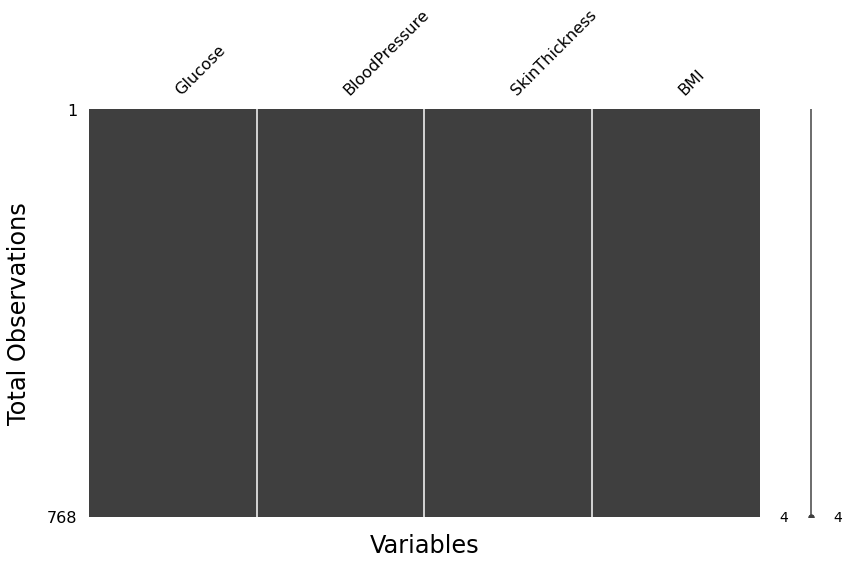

In [15]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(fill_data, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show()

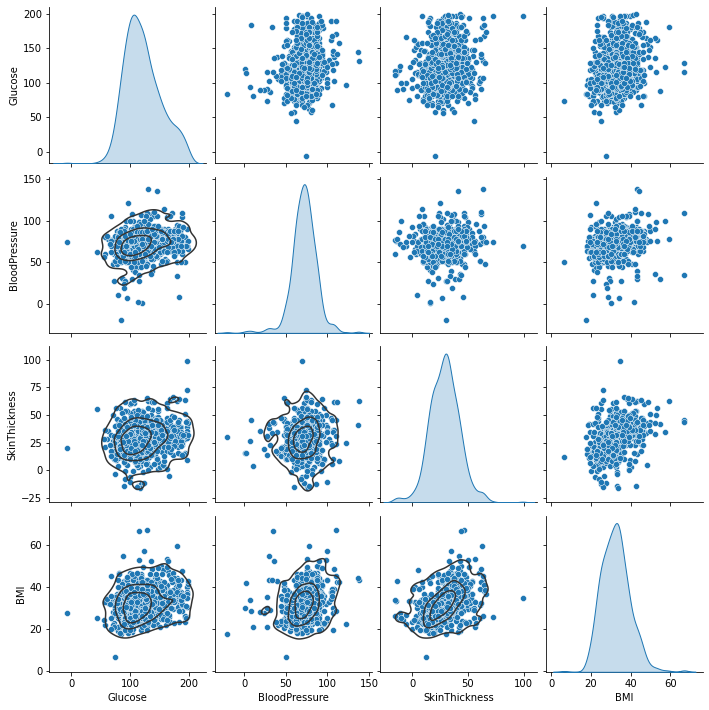

In [16]:
g_filled = sns.pairplot(fill_data, diag_kind="kde")
g_filled.map_lower(sns.kdeplot, levels=4, color=".2")

#### 첫 분포와 비교해보면 skinthickness의 분포도 나머지 3개 처럼 첫 분포와 비슷한 양상을 띔
#### good~